#### <span style="color:#dcdc9f;font-weight: 600">Imports iniciais</span>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### <span style="color:#dcdc9f;font-weight: 600">Configurando</span>

In [ ]:
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")

#### <span style="color:#dcdc9f;font-weight: 600">Lendo e mostrando dados não tratados</span>

In [ ]:
df = pd.read_csv('../Resultados/metricas_resultados.csv', delimiter=';')
df.head()

#### <span style="color:#dcdc9f;font-weight: 600">Configurando</span>

In [ ]:
# df.describe(include='all')
df.groupby("Tipo")["Duração (ms)"].describe()

#### <span style="color:#dcdc9f;font-weight: 600">Desempenho por número de threads (somente paralelos)</span>

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df[df["Tipo"].str.contains("Paralelo", case=False, na=False)],
    x="Quant. de threads", y="Duração (ms)",
    hue="Tamanho do array", marker="o"
)
plt.title("Desempenho do algoritmo paralelo por número de threads")
plt.xlabel("Quantidade de threads")
plt.ylabel("Duração (ms)")
plt.show()

#### <span style="color:#dcdc9f;font-weight: 600">Comparação Serial x Paralelo</span>

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df, x="Tamanho do array", y="Duração (ms)",
    hue="Tipo"
)
plt.title("Comparação de desempenho: Serial vs Paralelo")
plt.xlabel("Tamanho do array")
plt.ylabel("Duração (ms)")
plt.show()

#### <span style="color:#dcdc9f;font-weight: 600">Cálculo de Speedup (Serial / Paralelo)</span>

In [ ]:
base_serial = (
    df[df["Tipo"].str.contains("Serial", case=False, na=False)]
    .set_index("Tamanho do array")["Duração (ms)"]
)

def calcular_speedup(row):
    if "Paralelo" in row["Tipo"]:
        return base_serial.get(row["Tamanho do array"], None) / row["Duração (ms)"]
    return 1

df["Speedup"] = df.apply(calcular_speedup, axis=1)

plt.figure(figsize=(8,5))
sns.lineplot(
    data=df[df["Tipo"].str.contains("Paralelo", case=False, na=False)],
    x="Quant. de threads", y="Speedup",
    hue="Tamanho do array", marker="o"
)
plt.title("Speedup do algoritmo paralelo")
plt.xlabel("Quantidade de threads")
plt.ylabel("Speedup (vezes mais rápido que Serial)")
plt.show()

#### <span style="color:#dcdc9f;font-weight: 600">Relações entre variáveis (Pairplot)</span>

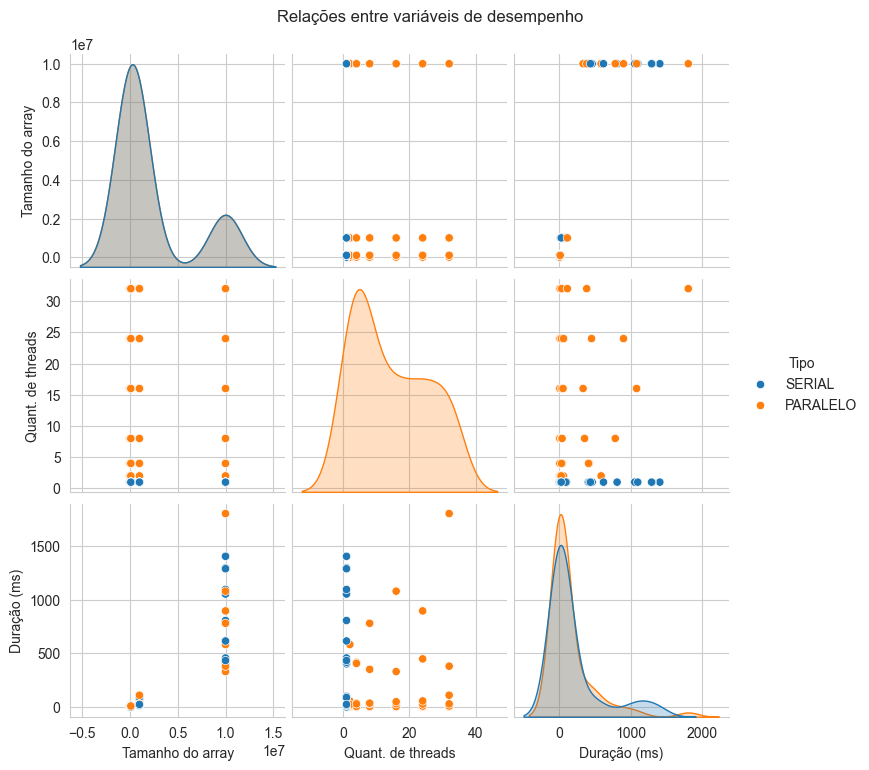

In [15]:
sns.pairplot(
    df,
    vars=["Tamanho do array", "Quant. de threads", "Duração (ms)"],
    hue="Tipo"
)
plt.suptitle("Relações entre variáveis de desempenho", y=1.02)
plt.show()